In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import make_filter, convolution, minimize_mle, minimize_map, hankel, inv_hessian

References and extra reading:

GLM Tutorial from Jonathan Pillow : https://github.com/pillowlab/GLMspiketraintutorial

Laplace approximation : Pattern Recognition and Machine Learning, Christophe M. Bishop, Chapter 4, Section 4.5.1




### Part 4:   Fitting an Linear Nonlinear Poisson (LNP) model with maximum a posteriori (MAP)

We can maximise the likelihood of a generalized linearm model (GLM) to estimate the parameters that best fit a given dataset. However, sometimes, we want to incorporate prior assumptions about the parameters while fitting them e.g. smoothness. 
For an LNP model with a parameters $\boldsymbol{\omega}$ and input stimulus $\mathbf{x}_{1:T}$, the likelihood of the output spike train $y_{1:T}$ is:

### $p(y_{1:T} | \boldsymbol{\omega}, \mathbf{x}_t) = \underset{t=1}{\overset{T}{\prod}}\frac{1}{y_t !}r_t^{y_t}\exp^{-r_t}$


$r_t$ is the predicted firing rate in timebins $t$ from the LNP model, assuming the canonical $\exp()$ nonlinearity:

### $r_t = \exp(\boldsymbol{\omega} * \mathbf{x}_{t-k\text{ }:\text{ }t})$

In order to incorporate prior assumptions about the parameters $\boldsymbol{\omega}$, we _assume_ a prior distribution  $p(\boldsymbol{\omega})$ over $\boldsymbol{\omega}$.

From Bayes' rule, we know that:

### $p(\boldsymbol{\omega}|y_{1:T}, \mathbf{x}_{1:T})\text{    }p(y_{1:T} | \mathbf{x}_{1:T}) = p(y_{1:T}| \boldsymbol{\omega}, \mathbf{x}_{1:T})\text{    }p(\boldsymbol{\omega})$ 

### $\begin{align*}
\implies p(\boldsymbol{\omega}|y_{1:T}, \mathbf{x}_{1:T}) &\propto p(y_{1:T}| \boldsymbol{\omega}, \mathbf{x}_{1:T})\text{    }p(\boldsymbol{\omega})\\
\text{posterior  } &\propto \text{likelihood x prior}
\end{align*}$

Hence, by multiplying the prior to the likleihood and calculating $\log$ of this equation, we now maximise the log posterior of the parameters given the data:

### $
\begin{align}
\log p(\boldsymbol{\omega}|y_{1:T}, \mathbf{x}_{1:T}) &= \log(p(y_{1:T}| \boldsymbol{\omega}, \mathbf{x}_{1:T}) + \log p(\boldsymbol{\omega}) + C\\
  &= \underset{t=1}{\overset{T}{\sum}}\Big(y_t * \log r_t - r_t - \log(y_t !)\Big) + \log p(\boldsymbol{\omega}) + C
\end{align}$

Note that if the prior is also concave, then the log posterior is guaranteed to be concave, and so, there is a single global optimum with respect to the parameters $\boldsymbol{\omega}$.

Additionally, we can use the second derivative of the log posterior (aka the Hessian), to calculate the error bars (or the posterior variance $\Sigma_{\text{post}}$) of the parameters using the Laplace approximation (see References).

### $\Sigma_{\text{post}} = -\big(\nabla\nabla \log p(\boldsymbol{\omega}_{\text{MAP}}|y_{1:T}, \mathbf{x}_{1:T})\big)^{-1}$

**Questions:**

a) Assume that the parameters $\boldsymbol{\omega}$ follow a multivariate Gaussian distribution with mean 0 and the identity matrix as the covariance matrix i.e.:

$\boldsymbol{\omega} \sim \mathcal{N}\big(\boldsymbol{0}, \mathbf{I}\big)$

Write down the log posterior of the LNP model, the gradient of the log posterior of the log posterior with respect to $\boldsymbol{\omega}$

Hint : the log prior is $\underset{k=1}{\overset{K}{\sum}}\boldsymbol{\omega}^2_k$ where $K$ is the length of $\boldsymbol{\omega}$

b) Using a fixed filter and baseline, simulate responses $\mathbf{y}^{real}$ from an LNP model, as in Part 2 of the previous tutorial. Save the response and stimulus values -- these will be our groundtruth (real) dataset.

b) Calculate the STA for these responses

c) Write down a Python function that takes as input the LNP parameters (filter and baseline), the groundtruth stimulus and the groundtruth responses, and returns the 

    i) log likelihood of the model. (Hint : check your function against the log_likelihood() method in utils.py)
    ii) log posterior of the model. (Hint : check your function against the log_posterior() method in utils.py)

d) Get the MLE estimate of the parameters using the minimize_mle() method from utils.py

e) Get the MAP estimate of the parameters using the minimize_map() method fro utils.py

f) Compare the MLE estimate, MAP estimate, the STA and the true filter. 

h) _Optional_: 
- Calculate the second derivate of the log posterior with repect to the parameters (aka the Hessian). Show that the Hessian of the log posterior is a negative semidefinite matrix. (Hint: a matrix $A$ is negative semidefinite, if for any vector $a$, $a^TXa \leq 0$)

- Write down a function that takes as input the LNP parameters (filter and baseline), the groundtruth stimulus and the groundtruth responses, and returns the inverse of the Hessian. (Hint : check your function against the inv_hessian() method in utils.py)

- Use the inverse obtained from calling the method inv_hessina() to plot errorbars for the MAP estimate of the parameters. (Remember the _variance_ of the parameters is the diagonal of the _negative_ inverse Hessian)

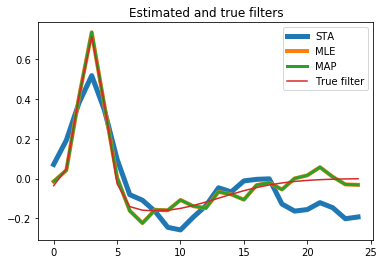

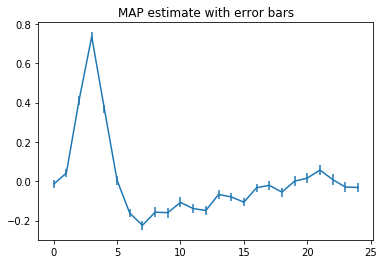

In [42]:
# Sample code

# Make filter, set baseline

# a) Set the filter and baseline values
stim_lags = 25
dt = .1
_filter = make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)
baseline = 0.

# Generate stimulus and responses

# Generate stimulus
stim = np.random.normal(size=100)

#Make repeats of stimulus
stim = np.tile(stim, 200).reshape(200, -1)

# Calculate firing rate
z = convolution(_filter, stim) + baseline
r = np.exp(z)
# Simulate from model
y = np.random.poisson(dt * r)


# Calculate the STA
X = hankel(stim_lags, stim)
sta = y.flatten().dot(X) / y.sum()

# Call minimize_mle() from utils.py to get MLE estimates
w_mle, b_mle = minimize_mle(stim, y, stim_lags, dt)

# Call minimize_map() from utils.py to get MAP estimates
w_map, b_map = minimize_map(stim, y, stim_lags, dt)

# Plot STA, MLE and MAP estimates for the filter:
plt.title("Estimated and true filters")
plt.plot(sta / np.linalg.norm(sta), lw=5, label='STA')
plt.plot(w_mle, lw=4, label='MLE')
plt.plot(w_map, lw=3, label="MAP")
plt.plot(_filter, label="True filter")
plt.legend()
plt.show()

H_filter, H_baseline = inv_hessian(np.append(w_map, b_map), stim, y, dt)
error_filter = np.sqrt( np.diag( - H_filter ) )

plt.title("MAP estimate with error bars")
plt.errorbar(range(stim_lags), w_map, yerr=error_filter)
plt.show()

In [3]:
# Your code here:





### Part 5 (Optional): Construct an LNP model for coupled neurons

For generating realistic spike counts from a population of neurons using the LNP model, the firing rate should also depend on the A) a neuron's individual spike-history B) the spike history of other neurons in the population. 

Here we simulate 2 coupled neurons using the LNP model. The spike count of each neuron depends on a common stimulus input, it's own spiking history and the other neuron's spiking history:

$\begin{align}
r^{(1)}_t &= exp(\sum_{k=1}^K \omega^{(1)}_k x_{t-k} + \sum_{n=1}^N h^{\text{self}}_n y^{(1)}_{t-n} +  \sum_{n=1}^N h^{\text{other}}_n y^{(2)}_{t-n} + b^{(1)})\\
r^{(2)}_t &= exp(\sum_{k=1}^K \omega^{(2)}_k x_{t-k} + \sum_{n=1}^N h^{\text{self}}_n y^{(2)}_{t-n} +  \sum_{n=1}^N h^{\text{other}}_n y^{(1)}_{t-n} + b^{(2)})\\
y^{(1)}_t &\sim \text{Poisson}(r^{(1)}\Delta t)\\
y^{(2)}_t &\sim \text{Poisson}(r^{(2)}\Delta t)
\end{align}$


Thus, at every timebin, in addition to the stimulus, the model should also receive as input, its own previous spikes (a vector of length $N$), weighted by the vector $\mathbf{h}^{\text{self}}$ of size $N$, and previous from other the neuron, weighted by a vector $\mathbf{h}^{\text{other}}$ of size $N$. We can rewrite the equations as follows:

$\mathbf{r}_t = W*\mathbf{x}_{t-K:t} + H\cdot\mathbf{y}_{t-N:t}$

where $\mathbf{r}_t = [r^{(1)}_t\text{    }r^{(2)}_t]$, $\mathbf{y}_t = [y^{(1)}_t\text{    }y^{(2)}_t]$, $W = [\omega^{(1)}\text{    }\omega^{(2)}]$, $H = \begin{bmatrix}
h^{\text{self}} & h^{\text{other}} \\
h^{\text{other}} & h^{\text{self}}
\end{bmatrix}$  

Algorithmically, this means that we can only generate spikes sequentially.

**Questions:**

a) Use the make_filter() method from utils.py to generate 2 stimulus filters for the 2 neurons, 1 spike-history filter $h^{\text{self}}$ and 1 cross-coupling filter $h^{\text{self}}$. 

b) Simulate responses $\mathbf{y}$ from this model to 200 repeats of Gaussian white noise stimulus of length 100. Calculate the peristimulus time histogram (PSTH) of each neuron's responses separately and compare it to the predicted rate $r$ from the model -- the 2 should match.

c) Calculate the STA for each neuron's filter.

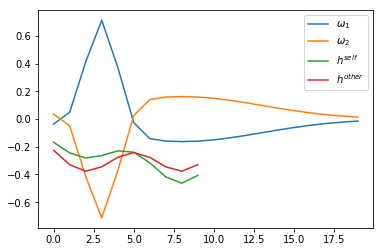

In [88]:
# Sample code


# Make filters for ω and h, set baseline
stim_lags = 20
hst_lags = 10
baseline_1 = 2
baseline_2 = 2
dt = .01
w_1 = make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)
w_2 = - make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)
h_self = - make_filter(lags=hst_lags, mu1=8., mu2=2., s1=2., s2=2., eta=-.6)
h_other =  - make_filter(lags=hst_lags, mu1=8., mu2=2., s1=2., s2=2., eta=-1.)

plt.plot(w_1, label='$\omega_1$')
plt.plot(w_2, label='$\omega_2$')
plt.plot(h_self, label='$h^{self}$')
plt.plot(h_other, label='$h^{other}$')
plt.legend()

In [89]:
# Generate stimulus
stim = np.random.normal(size=100)
stim = np.tile(stim, 200).reshape(200, -1)

# Calculate log firing rate from stimulus filter & baseline terms
X = hankel(stim_lags, stim)
z_1 = X.dot(w_1).reshape(200, -1) + baseline_1
z_2 = X.dot(w_2).reshape(200, -1) + baseline_2

y_1 = np.zeros_like(stim)
r_1 = np.zeros_like(stim)

y_2 = np.zeros_like(stim)
r_2 = np.zeros_like(stim)

# Simulate responses
y_1[:, :hst_lags] = np.random.poisson(np.exp(z_1[:, :hst_lags]))
y_2[:, :hst_lags] = np.random.poisson(np.exp(z_2[:, :hst_lags]))

for t in range(hst_lags, stim.shape[1]):
    # Update log firing rate
    z_1[:, t] += z_1[:, t] + y_1[:, t-hst_lags : t].dot(h_self) + y_2[:, t-hst_lags : t].dot(h_other)
    z_2[:, t] += z_2[:, t] + y_2[:, t-hst_lags : t].dot(h_self) + y_1[:, t-hst_lags : t].dot(h_other)
    
    # Calculate firing rate
    r_1[:, t] = np.exp(z_1[:, t])
    r_2[:, t] = np.exp(z_2[:, t])
    
    # Calculate response
    y_1[:, t] = np.random.poisson(dt * r_1[:, t])
    y_2[:, t] = np.random.poisson(dt * r_2[:, t])
    

In [100]:
# Calculate STA
sta_1 = y_1.flatten().dot(X) / y_1.sum()
sta_2 = y_2.flatten().dot(X) / y_2.sum()

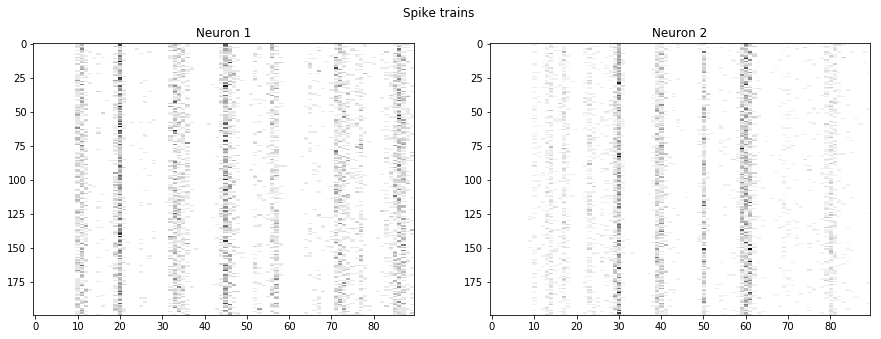

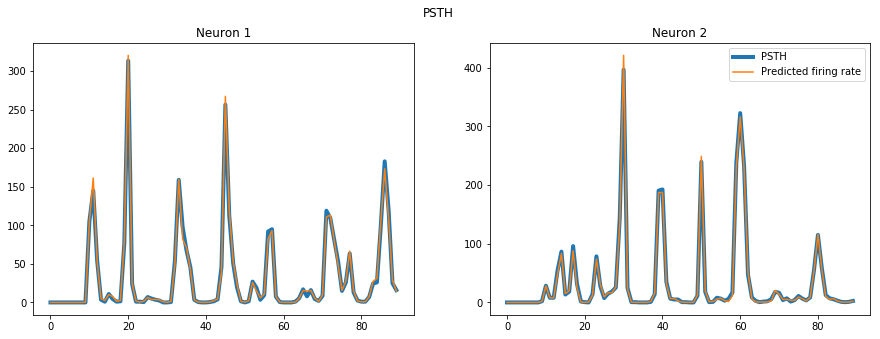

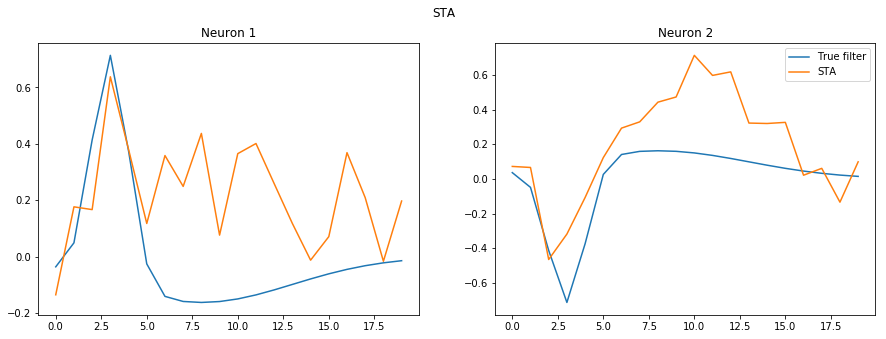

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Spike trains")
ax1.set_title("Neuron 1")
ax1.imshow(y_1[:, hst_lags:], cmap='binary', aspect='auto')
ax2.set_title("Neuron 2")
ax2.imshow(y_2[:, hst_lags:], cmap='binary', aspect='auto')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("PSTH")
ax1.set_title("Neuron 1")
ax1.plot(y_1[:, hst_lags:].mean(0) / dt, lw=4, label='PSTH')
ax1.plot(r_1[:, hst_lags:].mean(0), label="Predicted firing rate")
ax2.set_title("Neuron 2")
ax2.plot(y_2[:, hst_lags:].mean(0) / dt, lw=4, label='PSTH')
ax2.plot(r_2[:, hst_lags:].mean(0), label="Predicted firing rate")
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("STA")
ax1.set_title("Neuron 1")
ax1.plot(w_1, label="True filter")
ax1.plot(sta_1, label='STA')
ax2.set_title("Neuron 2")
ax2.plot(w_2, label='True filter')
ax2.plot(sta_2, label="STA")
plt.legend()
plt.show()
